In [15]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted

class MultinomialSyntheticDataGenerator(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=None):
        """
        A custom estimator for generating synthetic data using multinomial logistic regression,
        with the feature distribution inferred from the training data.
        
        Parameters:
        - n_samples (int): Number of synthetic samples to generate.
        - random_state (int): Seed for reproducibility.
        """
        self.random_state = random_state
        np.random.seed(self.random_state)


    def fit(self, X, y):
        """
        Fits a multinomial logistic regression model to the data and estimates the feature distribution.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        - y (ndarray): Target labels of shape (n_samples,).
        
        Returns:
        - self: The fitted instance.
        """
        # Store mean and covariance of features
        self.classes_ = np.unique(y)
        self.feature_mean_ = np.mean(X, axis=0)
        self.feature_cov_ = np.cov(X, rowvar=False)
        
        # Fit a logistic regression model
        self.model_ = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=self.random_state)
        self.model_.fit(X, y)
        
        # Store the number of classes and features
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        return self

    def predict_proba(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict_proba(X)
    

    def predict(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict(X)

    def generate(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        X_synthetic = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        
        # Compute class probabilities
        P_Y_given_X = self.predict_proba(X_synthetic)
        
        # Sample synthetic labels
        y_synthetic = np.array([np.random.choice(self.n_classes_, p=probs) for probs in P_Y_given_X])
        
        return X_synthetic, y_synthetic


    def generate_instances(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        
        X = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        return X



In [16]:
class OracleAnnotator:
    def __init__(self,mapie_clf, generator):
        self.mapie_clf = mapie_clf
        self.classes_ = mapie_clf.classes_
        self.generator = generator

    def generate_pairs_in_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        X = self.generator.generate_instances(n)
        X = np.repeat(X, repeats=2, axis=0)

        y = np.hstack([np.random.choice(self.classes_, size=2, replace=False) for _ in range(n)])

        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)
        return X_pairs, y_pairs


    def generate_pairs_cross_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        
        X = self.generator.generate_instances(2*n)
        y = np.random.choice(self.classes_, size=2*n, replace=True)
        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs
    
    def create_pairs_for_classification_data(self, X):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        # Generate synthetic features based on the inferred distribution
        
        X = self.generator.generate_instances(2*n)
        y = np.random.choice(self.classes_, size=2*n, replace=True)
        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.mapie_clf.estimator.predict_proba(X)
        scores = self.mapie_clf.conformity_score_function_.get_conformity_scores(
                        y, y_pred_proba, y_enc=y
                    )
        return scores

In [4]:
from venv import create
from util.ranking_datasets import DyadOneHotPairDataset

def create_dyads(X,y, n_classes):
    y_1h = np.eye(n_classes)[y.reshape(-1)].reshape(*y.shape, n_classes)
    dyads = np.concatenate((X, y_1h.squeeze()), axis=1)
    return dyads

X_seed, y_seed = make_classification(n_samples=1000, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42)
conformity_score = APSConformityScore()
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_seed, y_seed)
X_cal, y_cal = generator.generate(n=100)
mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

# generate all possible pairs for a couple of instances

def create_training_data(n_instances):
    n_classes = len(generator.classes_)
    X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
    y_train = np.tile(generator.classes_, n_instances)
    conformities = oracle_annotator.get_conformity(X_train,y_train)
    sort_idx = (-conformities).argsort(axis=0).flatten()

    X_sorted = X_train[sort_idx]
    y_sorted = y_train[sort_idx]

    X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
    y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
    y_pairs = np.expand_dims(y_pairs, axis=-1)
    y_pairs_1h = np.eye(n_classes)[y_pairs.reshape(-1)].reshape(*y_pairs.shape, n_classes)
    dyads = np.concatenate((X_pairs, y_pairs_1h.squeeze()), axis=2)
    ds_1h = DyadOneHotPairDataset()
    ds_1h.create_from_numpy_dyad_pairs(dyads)
    return ds_1h

train_data = create_training_data(50)
val_data = create_training_data(20)

c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [5]:
from models.ranking_models import DyadRankingModel
import torch
model = DyadRankingModel(input_dim=6,hidden_dims=[12,12,12],activations=[torch.nn.Sigmoid(), torch.nn.ReLU(), torch.nn.Sigmoid()])

train_loader = DataLoader(train_data, 64)
val_loader = DataLoader(val_data, 64)


model._fit(train_loader,val_loader=val_loader, num_epochs=1000, patience=150)

Stopping training.


In [18]:
def create_dyads(X,y, n_classes):
    y_1h = np.eye(n_classes)[y.reshape(-1)].reshape(*y.shape, n_classes)
    dyads = np.concatenate((X, y_1h.squeeze()), axis=1)
    return dyads

X_test, y_test = generator.generate(10)

conformities = oracle_annotator.get_conformity(X_test, y_test)

dyads_test= create_dyads(X_test, y_test, 3)
dyads_tensor = torch.tensor(dyads_test, dtype=torch.float32)
skills = model(dyads_tensor).detach().cpu().numpy()
kendalltau(skills, conformities)


SignificanceResult(statistic=0.15555555555555553, pvalue=0.6006536596119929)

In [8]:
import torch

from models.ranking_models import SortLayer
X_seed, y_seed = make_classification(n_samples=1000, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42)
conformity_score = APSConformityScore()
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_seed, y_seed)
X_cal, y_cal = generator.generate(n=100)
mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

# generate all possible pairs for a couple of instances
n_instances = 100
n_classes = len(generator.classes_)
n_obs = n_instances * n_classes
X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
y_train = np.tile(generator.classes_, n_instances)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]
conformities_sorted = conformities[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs, axis=-1)


ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
model = LabelRankingModel(input_dim=X_train.shape[1], hidden_dims=[2*X_train.shape[1],X_train.shape[1]], activations=[torch.nn.Sigmoid(),SortLayer()],output_dim=len(generator.classes_))
pair_loader = DataLoader(ds, batch_size=64)
model.num_classes = generator.n_classes_
model._fit(pair_loader, val_loader=None, num_epochs=250, learning_rate=0.01)


# generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
X_test, y_test = X_train, y_train
conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
print("in-sample: ", tau_corr)
X_test, y_test = generator.generate(n=10)
conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
print("out-of-sample: ", tau_corr)


c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


in-sample:  0.7567892976588629
out-of-sample:  0.6888888888888888


In [ ]:
X_seed, y_seed = make_classification(n_samples=1000, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42)
conformity_score = LACConformityScore()
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_seed, y_seed)
X_cal, y_cal = generator.generate(n=100)
mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

# generate all possible pairs for a couple of instances
n_instances = 50
n_classes = len(generator.classes_)
n_obs = n_instances * n_classes
X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
y_train = np.tile(generator.classes_, n_instances)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]
conformities_sorted = conformities[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs, axis=-1)


ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
model = LabelRankingModel(input_dim=X_train.shape[1], hidden_dims=[2*X_train.shape[1]], output_dim=len(generator.classes_))
pair_loader = DataLoader(ds, batch_size=64)
model.num_classes = generator.n_classes_
model._fit(pair_loader, val_loader=None, num_epochs=1000, learning_rate=0.01)


# generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
X_test, y_test = X_train, y_train
conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
print("in-sample: ", tau_corr)
X_test, y_test = generator.generate(n=10)
conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
print("out-of-sample: ", tau_corr)


In [29]:
from mapie.classification import MapieClassifier
from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore, TopKConformityScore
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import make_classification
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from models.ranking_models import SortLayer
import torch

def conduct_oracle_experiment(conformity_score, num_pairs_to_check, generator, X_cal, y_cal):
    tau_corrs = []
    # Generate a small dataset

    mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
    # create mapie classifier for conformity scores
    mapie_clf.fit(X_cal, y_cal)
    # create 
    oracle_annotator = OracleAnnotator(mapie_clf, generator)

    for num_pairs in num_pairs_to_check:
        X_pairs, y_pairs = oracle_annotator.generate_pairs_cross_instance(num_pairs)
        ds = LabelPairDataset()
        ds.create_from_numpy_pairs(X_pairs, y_pairs)
        model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), SortLayer(),torch.nn.Identity()], output_dim=len(generator.classes_))
        pair_loader = DataLoader(ds, batch_size=64)
        model.num_classes = generator.n_classes_
        model._fit(pair_loader, val_loader=None, num_epochs=1000, learning_rate=0.01)


        # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
        X_test, y_test = generator.generate(n=100)
        skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
        conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
        tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
        tau_corrs.append(tau_corr)
    return tau_corrs, skills_from_model, conformity_scores

In [30]:
num_pairs_to_check = np.geomspace(2**4,2**12,3).astype(int)
X_train, y_train = make_classification(
    n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
)

# Initialize and fit the generator
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_train, y_train)
X_cal, y_cal = generator.generate(n=100)
tau_corrs_LAC, skills_LAC, conformities_LAC = conduct_oracle_experiment(LACConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)
tau_corrs_APS, skills_APC, conformities_APC = conduct_oracle_experiment(APSConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)
tau_corrs_TopK, skills_TopK, conformities_TopK = conduct_oracle_experiment(TopKConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)
# tau_corrs_Naive, skills_Naive, conformities_Naive = conduct_oracle_experiment(NaiveConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)

/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


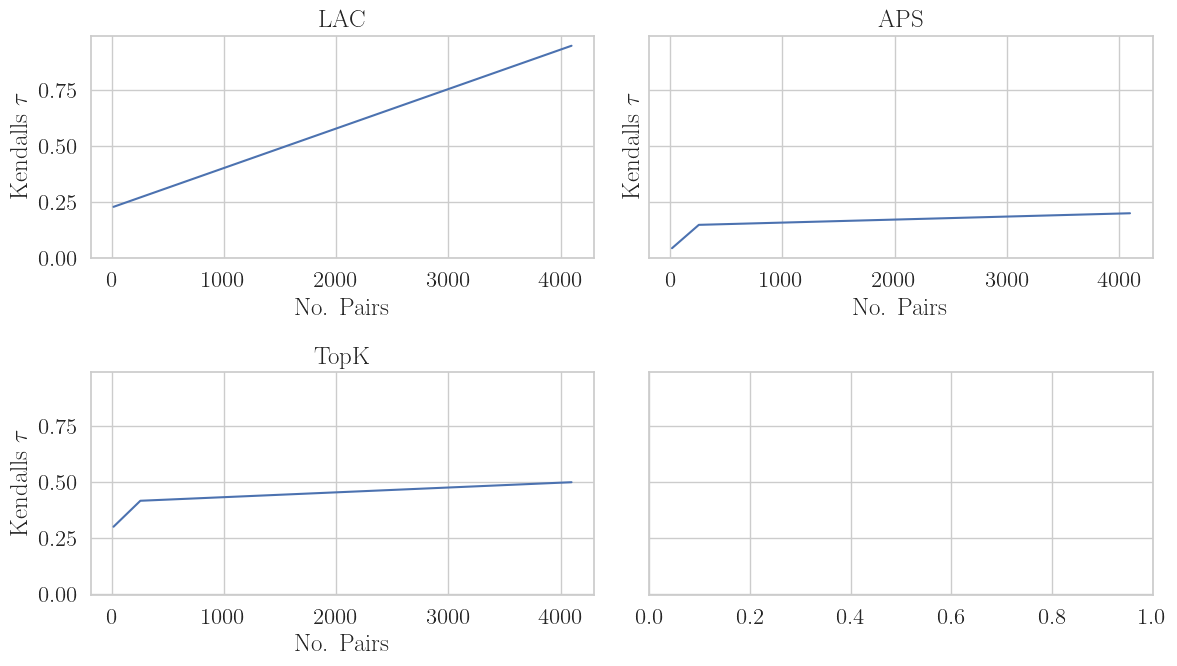

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 7)



fig, axes = plt.subplots(2,2, sharey=True)
axes = axes.ravel()

axes[0].set_title("LAC")
axes[0].set_ylabel(r"Kendalls $\tau$")
axes[0].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_LAC, ax = axes[0])
axes[1].set_title("APS")
axes[1].set_ylabel(r"Kendalls $\tau$")
axes[1].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])
axes[2].set_title("TopK")
axes[2].set_ylabel(r"Kendalls $\tau$")
axes[2].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_TopK, ax = axes[2])
fig.tight_layout()
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])